# Import

In [1]:
import pandas as pd
import gtfs_kit as gk
import warnings
import helper
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder
from scipy.stats import pointbiserialr,pearsonr

from sklearn.ensemble import RandomForestClassifier
import joblib

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Load Datasets

In [2]:
# Load the gtfs we generated with the various csv file created in the preprocessing
feed = gk.feed.read_feed('../processed_files/preprocessing_gtfs_static.zip',dist_units="km")
stop_times = feed.get_stop_times()
gtfs_static_stats = stop_times.copy()

# Load complete gtfs static - delays and weather dataset
main_dataset = pd.read_csv("../processed_files/df_linea.csv", index_col=[0])
main_dataset = main_dataset.assign(isArrivoRitardo=None)
main_dataset = main_dataset.assign(isPartenzaRitardo=None)

In [3]:
for index,row in main_dataset.iterrows():
    if (row['ritardo_arrivo'] >= 1):
        main_dataset.loc[index,'isArrivoRitardo'] = 1
    else:
        main_dataset.loc[index,'isArrivoRitardo'] = 0
    if (row['ritardo_partenza'] >= 1):
        main_dataset.loc[index,'isPartenzaRitardo'] = 1
    else:
        main_dataset.loc[index,'isPartenzaRitardo'] = 0

In [4]:
#Drop Columns
#main_dataset = main_dataset.drop(['ritardo_arrivo'], axis=1)

# Basic - Statistics

In [5]:
gtfs_static_stats = gtfs_static_stats.loc[gtfs_static_stats.stop_sequence != 1]

## gtfs_static_stats.describe()

## Stops

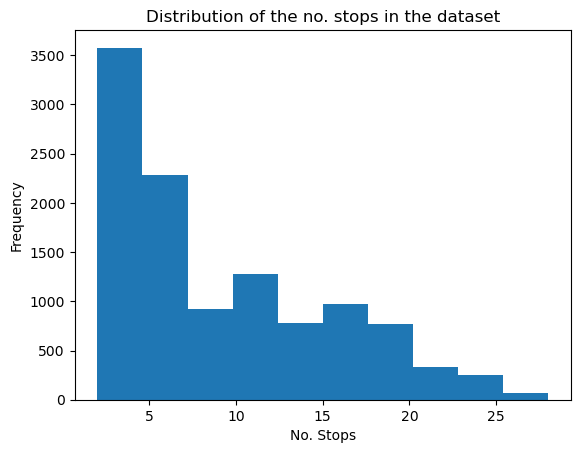

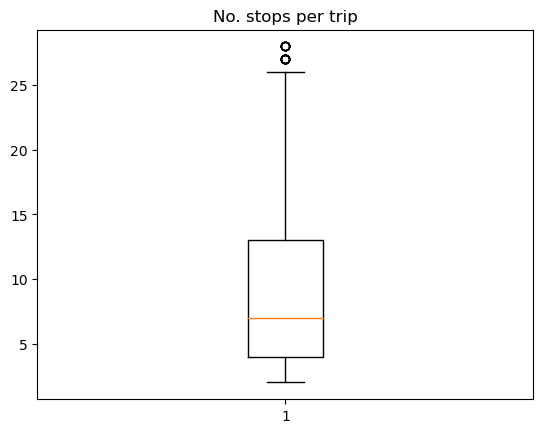

In [6]:
# Distribution of number of stops in the dataset
plt.title('Distribution of the no. stops in the dataset')
plt.hist(gtfs_static_stats.stop_sequence)
plt.xlabel('No. Stops')
plt.ylabel('Frequency')
plt.savefig('../images/data_analytics_images/stop_sequence_gtfs_static_statistics.png')
plt.show()
# Box Plot
plt.boxplot(gtfs_static_stats.stop_sequence)
plt.title('No. stops per trip')
plt.savefig('../images/data_analytics_images/stop_sequence_gtfs_static_box_plot.png')
plt.show()

In [7]:
# Analytics on number of stop per trip
result = helper.calculate_stops(gtfs_static_stats)
result.head(30)

,last_stop_sequence,value
0,2,0
1,3,6
2,4,16
3,5,579
4,6,93
5,7,24
6,8,48
7,9,8
8,10,0
9,11,6


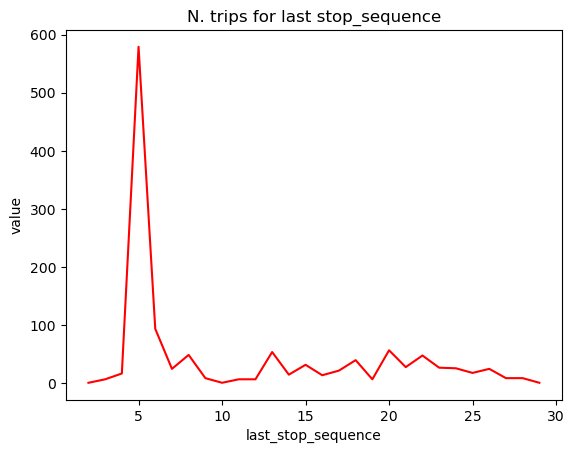

In [8]:
plt.title('N. trips for last stop_sequence')
# Plot total 
plt.plot(result['last_stop_sequence'], result['value'], color='r')
plt.xlabel('last_stop_sequence')
plt.ylabel('value')
plt.savefig('../images/data_analytics_images/number_stops_gtfs_static_plot.png')
plt.show()

## Time

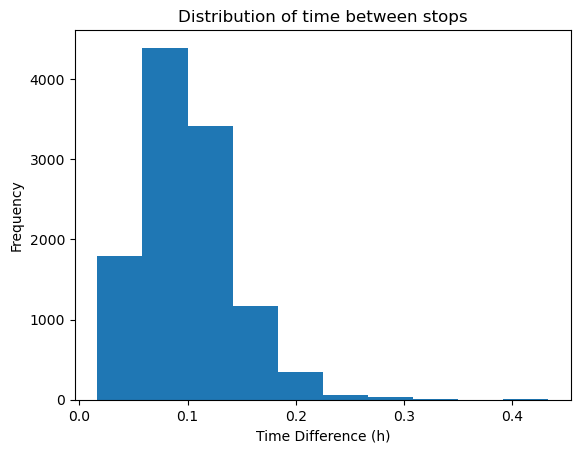

In [9]:
# Distribution of time in the dataset
plt.title('Distribution of time between stops')
plt.hist(gtfs_static_stats.time_diff)
plt.xlabel('Time Difference (h)')
plt.ylabel('Frequency')
plt.savefig('../images/data_analytics_images/time_gtfs_static_plot.png')
plt.show()

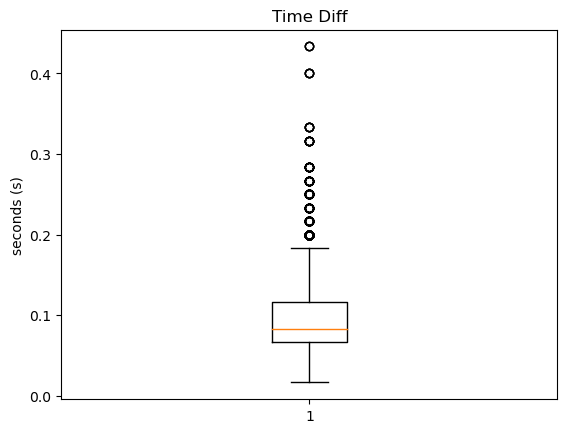

In [10]:
plt.boxplot(gtfs_static_stats.time_diff)
plt.title('Time Diff')
plt.ylabel("seconds (s)")
plt.savefig('../images/data_analytics_images/time_gtfs_static_box_plot.png')
plt.show()

## Distance

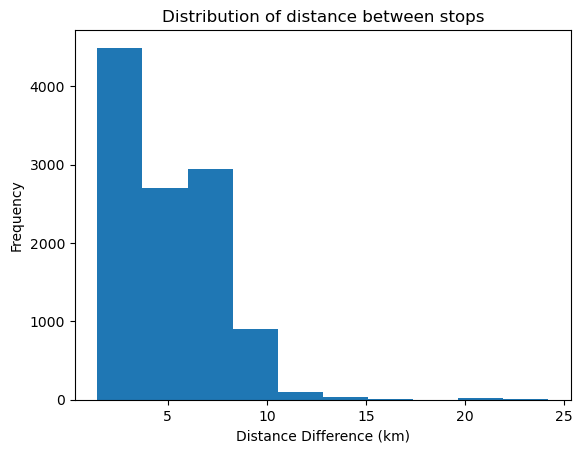

In [11]:
# Distribution of distance in the dataset
plt.title('Distribution of distance between stops')
plt.hist(gtfs_static_stats.dist_diff)
plt.xlabel('Distance Difference (km)')
plt.ylabel('Frequency')
plt.savefig('../images/data_analytics_images/distance_gtfs_static_plot.png')
plt.show()

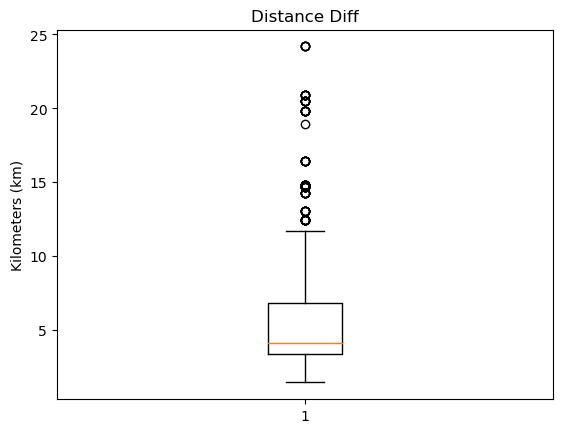

In [12]:
plt.boxplot(gtfs_static_stats.dist_diff)
plt.title('Distance Diff')
plt.ylabel("Kilometers (km)")
plt.savefig('../images/data_analytics_images/distance_gtfs_static_box_plot.png')
plt.show()

## Speed

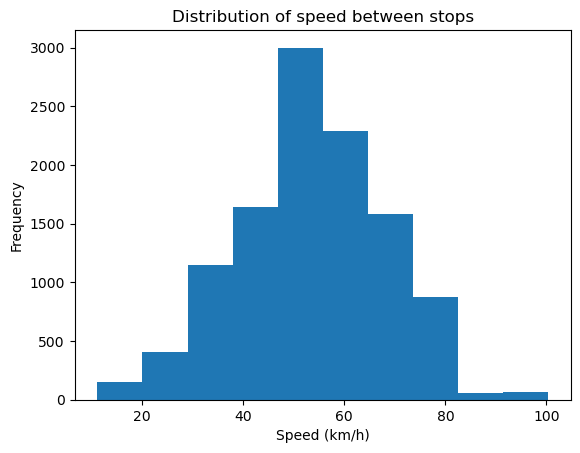

In [13]:
# Distribution of number of stops in the dataset
plt.title('Distribution of speed between stops')
plt.hist(gtfs_static_stats.speed)
plt.xlabel('Speed (km/h)')
plt.ylabel('Frequency')
plt.savefig('../images/data_analytics_images/speed_gtfs_static_plot.png')
plt.show()

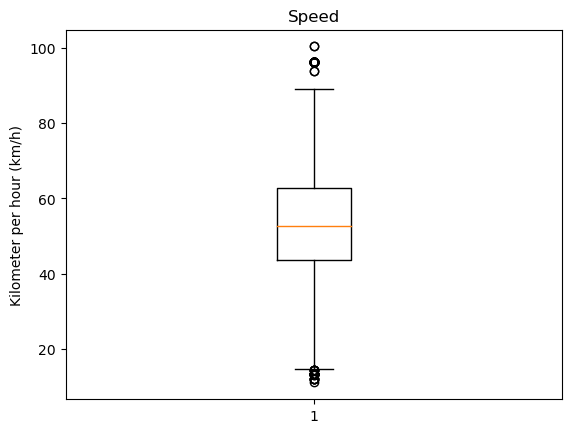

In [14]:
plt.boxplot(gtfs_static_stats.speed)
plt.title('Speed')
plt.ylabel("Kilometer per hour (km/h)")
plt.savefig('../images/data_analytics_images/speed_gtfs_static_box_plot.png')
plt.show()


## Corr Speed Time and Distance

In [15]:
df_corr = helper.dataset_for_scatter(stop_times)


/Users/gianlucarea/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


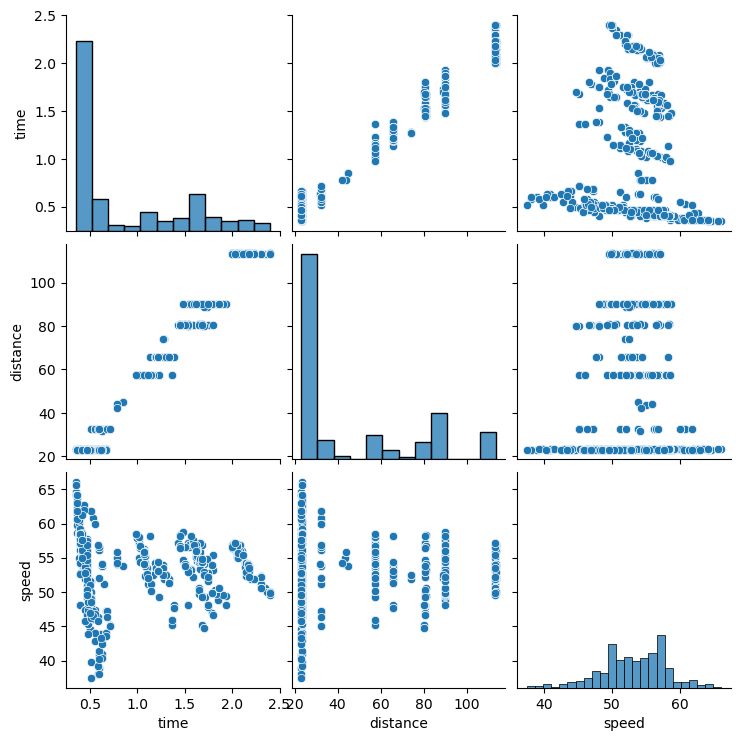

In [16]:
helper.correlogram_time_distance_speed(df_corr)

## Year Analytics

In [17]:
year_stats = helper.select_year_df('20210104','20220103')

In [18]:
year_stats = year_stats.groupby(['trip_id','service_id','date']).max('stop_sequence').reset_index()
week_division_dates = helper.calendar_2021()

result = pd.DataFrame(columns=['corse_totali', 'corse_veloci', 'corse_medie', 'corse_lente'], index=range(len(week_division_dates)-1)).fillna(0)
result.index += 1

#REGOLARE NUMERI CLUSTERING (Veloci , Medi, Lenti)
for i in range(len(week_division_dates)-1):
    ## Collecting all service date of trips on those days
    temp_analytics = year_stats.loc[(year_stats['date'] >= week_division_dates[i]) &
                                       (year_stats['date'] < week_division_dates[i+1])]
    for index, row  in temp_analytics.iterrows():
        result.at[i+1,'corse_totali'] += 1
        if(row.stop_sequence <= 5):
            result.at[i+1,'corse_veloci'] += 1
        if(row.stop_sequence > 5 and row.stop_sequence <= 10):
            result.at[i+1,'corse_medie'] += 1
        if(row.stop_sequence > 10):
            result.at[i+1,'corse_lente'] += 1

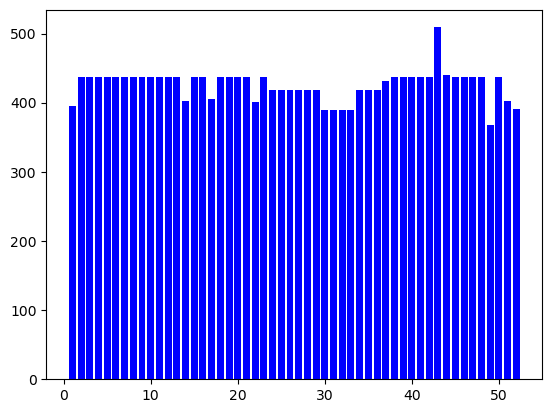

In [19]:
# Plot total 
plt.bar(result.index, result['corse_totali'], color='b')
plt.savefig('../images/year_analytics_total.png')
plt.show()

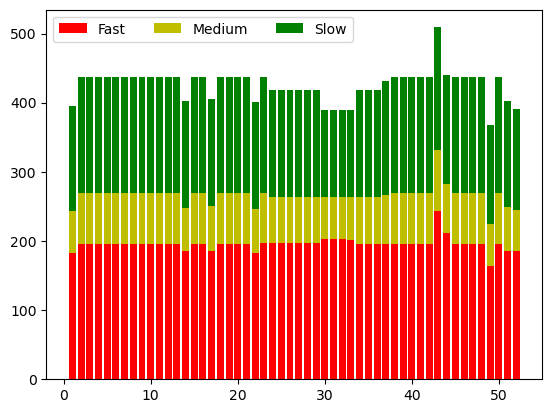

In [20]:
plt.bar(result.index, result['corse_veloci'], color='r',label='Fast')
plt.bar(result.index, result['corse_medie'], bottom=result['corse_veloci'], color='y',label='Medium')
plt.bar(result.index, result['corse_lente'],bottom=result['corse_veloci']+result['corse_medie'], color='g',label='Slow')
plt.legend(loc='upper left', ncols=3)

plt.savefig('../images/year_analytics_cluster_total.png')
plt.show()


# Advanced - Statistics


In [21]:
main_dataset = main_dataset.round({'speed':0,'temperature_linea':0,'wind_dir_10m_linea':0,'soil_temperature_linea':0 ,
                                  'wind_gusts_linea':0, 'wind_dir_100m_linea':0 ,'wind_speed_100m_linea':0,
                                  'wind_speed_10m_linea':0, 'wmo_code_linea':0 , 'humidity_linea':0}) 

In [22]:
main_dataset_copy = main_dataset.rename(columns={
    'codice_stazione_p': 'dep_station_code',
    'codice_stazione_a':'arr_station_code',
    'indice_tratta':'line_index',
    'codice':'code',
    'data_giorno':'day_date',
    'stop_code_p':'stop_code_d',
    'ritardo_partenza':'departure_delay',
    'ritardo_arrivo':'arrival_delay',
    'temperature_linea':'temperature_line',
    'app_temp_linea':'app_temp_line',
    'rain_linea':'rain_line',
    'snow_fall_linea':'snow_fall_line',
    'snow_depth_linea':'snow_depth_line',
    'humidity_linea':'humidity_line',
    'precipitation_linea':'precipitation_line',
    'wmo_code_linea':'wmo_code_line',
    'wind_speed_10m_linea':'wind_speed_10m_line',
    'wind_speed_100m_linea':'wind_speed_100m_line',
    'wind_dir_10m_linea':'wind_dir_10m_line',
    'wind_dir_100m_linea':'wind_dir_100m_line',
    'wind_gusts_linea':'wind_gusts_line',
    'soil_temperature_linea':'soil_temperature_line',
    'isArrivoRitardo':'isArrivalDelay',
    'isPartenzaRitardo':'isDepartureDelay'
})

In [23]:
# Point Biserial Correlation 
# encode categorical data into numeric values
labelEncoder = LabelEncoder()
main_dataset["trip_id"] = labelEncoder.fit_transform(main_dataset["trip_id"])
main_dataset["codice_stazione_p"] = labelEncoder.fit_transform(main_dataset["codice_stazione_p"])
main_dataset["codice_stazione_a"] = labelEncoder.fit_transform(main_dataset["codice_stazione_a"])
main_dataset_copy["trip_id"] = labelEncoder.fit_transform(main_dataset_copy["trip_id"])
main_dataset_copy["dep_station_code"] = labelEncoder.fit_transform(main_dataset_copy["dep_station_code"])
main_dataset_copy["arr_station_code"] = labelEncoder.fit_transform(main_dataset_copy["arr_station_code"])
# get continuous and dichotomous data
categorical = ['trip_id','arrival_time','departure_time','dep_station_code',
               'arr_station_code','line_index','shape_dist_traveled','time_diff',
               'speed','dist_diff','code','direction_id','day_date','stop_code_d',
               'stop_code_a','departure_delay','arrival_delay','temperature_line',
               'app_temp_line','rain_line','snow_fall_line','snow_depth_line','humidity_line',
               'precipitation_line','wmo_code_line','wind_speed_10m_line','wind_speed_100m_line',
               'wind_dir_10m_line','wind_dir_100m_line','wind_gusts_line','soil_temperature_line',
               'isArrivalDelay','isDepartureDelay'
              ]
numeric = ['trip_id','arrival_time','departure_time','dep_station_code',
           'arr_station_code','line_index','shape_dist_traveled','time_diff',
           'speed','dist_diff','code','direction_id','day_date','stop_code_d',
           'stop_code_a','departure_delay','arrival_delay','temperature_line',
           'app_temp_line','rain_line','snow_fall_line','snow_depth_line','humidity_line',
           'precipitation_line','wmo_code_line','wind_speed_10m_line','wind_speed_100m_line',
           'wind_dir_10m_line','wind_dir_100m_line','wind_gusts_line','soil_temperature_line',
           'isArrivalDelay','isDepartureDelay']
target = main_dataset_copy["isArrivalDelay"]



# Point Biserial Correlation
pbc = list()
for col in numeric:
    ans = pointbiserialr(main_dataset_copy[col], target)
    pbc.append([col, ans[0], ans[1]])
    
pbc_corr = pd.DataFrame(pbc, columns=["Feature", "CorrCoeff", "pValue"]).sort_values(by="CorrCoeff", ascending=False).reset_index(drop=True)

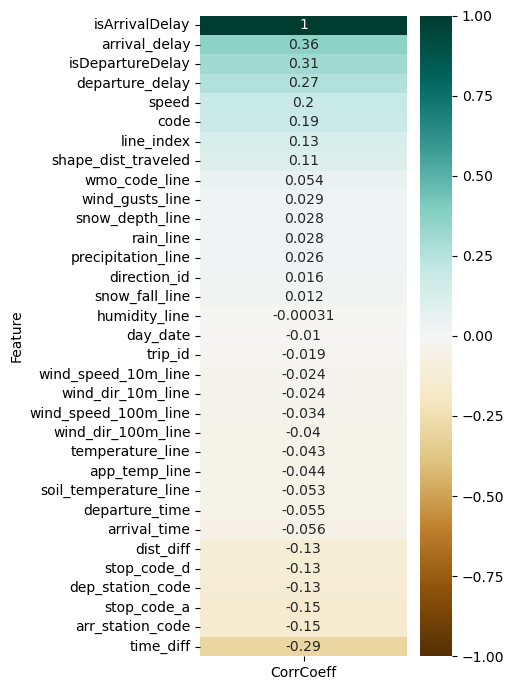

In [24]:
# Point biserial correlation
plt.figure(figsize=(5, 7))
pbc_corr = pbc_corr.set_index("Feature")
heatmap = sns.heatmap(pbc_corr[["CorrCoeff"]].sort_values(by="CorrCoeff", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
plt.tight_layout()
plt.savefig("../images/data_analytics_images/classification_pointbiserial_correlation.png")
del pbc_corr

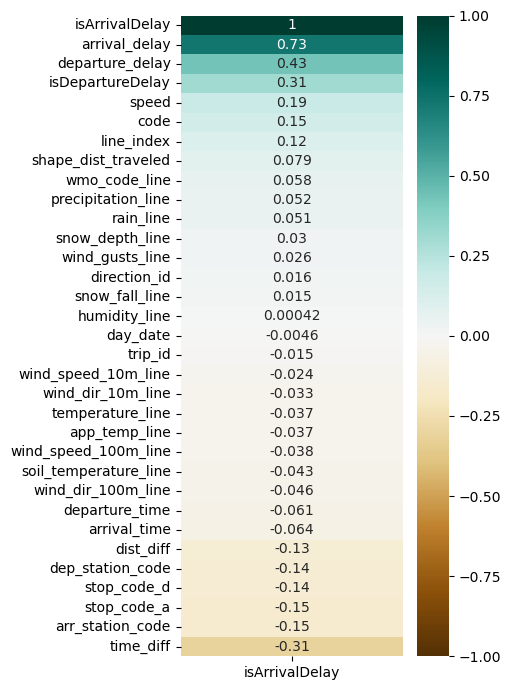

In [25]:
# Spearman correlation
plt.figure(figsize=(5, 7))
heatmap = sns.heatmap(main_dataset_copy[categorical].corr(method="spearman")[["isArrivalDelay"]].sort_values(by="isArrivalDelay", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
plt.tight_layout()
plt.savefig("../images/data_analytics_images/classification_spearman_correlation.png")
del heatmap

In [26]:
categorical = ['trip_id','arrival_time','departure_time','dep_station_code',
               'arr_station_code','line_index','shape_dist_traveled','time_diff',
               'speed','dist_diff','code','direction_id','day_date','stop_code_d',
               'stop_code_a','departure_delay','arrival_delay','temperature_line',
               'app_temp_line','rain_line','snow_fall_line','snow_depth_line','humidity_line',
               'precipitation_line','wmo_code_line','wind_speed_10m_line','wind_speed_100m_line',
               'wind_dir_10m_line','wind_dir_100m_line','wind_gusts_line','soil_temperature_line',
               'isArrivalDelay','isDepartureDelay'
              ]
numeric = ['trip_id','arrival_time','departure_time','dep_station_code',
           'arr_station_code','line_index','shape_dist_traveled','time_diff',
           'speed','dist_diff','code','direction_id','day_date','stop_code_d',
           'stop_code_a','departure_delay','arrival_delay','temperature_line',
           'app_temp_line','rain_line','snow_fall_line','snow_depth_line','humidity_line',
           'precipitation_line','wmo_code_line','wind_speed_10m_line','wind_speed_100m_line',
           'wind_dir_10m_line','wind_dir_100m_line','wind_gusts_line','soil_temperature_line',
           'isArrivalDelay','isDepartureDelay']
target = main_dataset_copy["arrival_delay"]

# Pearson Correlation
pc = list()
for col in numeric:
    ans = pearsonr(main_dataset_copy[col], target)
    pc.append([col,ans[0],ans[1]])
    
pc_corr = pd.DataFrame(pc, columns=["Feature", "CorrCoeff", "pValue"]).sort_values(by="CorrCoeff", ascending=False).reset_index(drop=True)

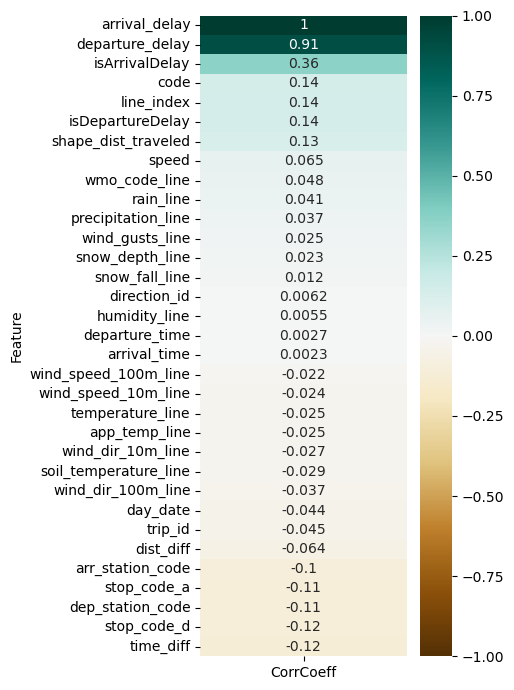

In [27]:
# Pearson correlation
plt.figure(figsize=(5, 7))
pc_corr = pc_corr.set_index("Feature")
heatmap = sns.heatmap(pc_corr[["CorrCoeff"]].sort_values(by="CorrCoeff", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
plt.tight_layout()
plt.savefig("../images/data_analytics_images/regression_pearson_correlation.png")
del pc_corr

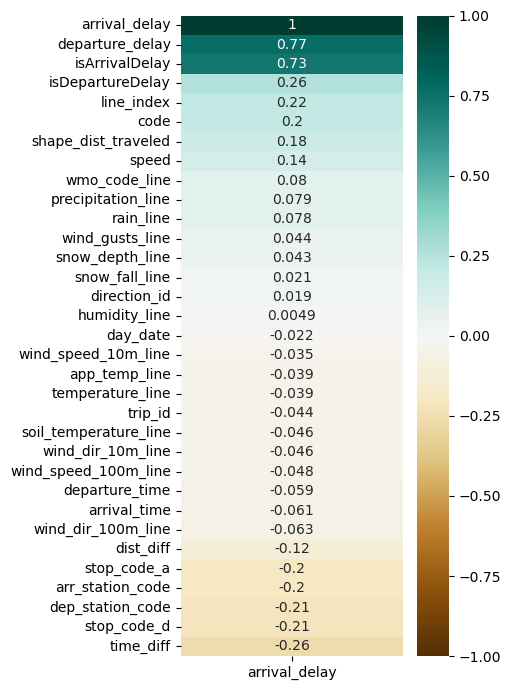

In [28]:
# Spearman correlation
plt.figure(figsize=(5, 7))
heatmap = sns.heatmap(main_dataset_copy[categorical].corr(method="spearman")[["arrival_delay"]].sort_values(by="arrival_delay", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
plt.tight_layout()
plt.savefig("../images/data_analytics_images/regression_spearman_correlation.png")
del heatmap

In [29]:
#Drop Columns
main_dataset_dropped = main_dataset.drop(['codice_stazione_p','codice_stazione_a'], axis=1)

In [30]:
main_dataset_dropped["isArrivoRitardo"] = main_dataset_dropped["isArrivoRitardo"].astype(float)
main_dataset_dropped["isPartenzaRitardo"] = main_dataset_dropped["isPartenzaRitardo"].astype(float)

In [31]:
X = main_dataset_dropped.loc[:, main_dataset_dropped.columns != "isArrivoRitardo"]
y = np.array(main_dataset_dropped.loc[:, main_dataset_dropped.columns == "isArrivoRitardo"]["isArrivoRitardo"])

model = RandomForestClassifier(n_estimators=100,
                       criterion="entropy", random_state=42, n_jobs=-1)

model.fit(X, y)

joblib.dump(model, "./Data/feature_importance_model.joblib")
model = joblib.load("./Data/feature_importance_model.joblib")
importances = model.feature_importances_
importances

array([1.69365683e-03, 5.58843864e-03, 4.97273306e-03, 1.06350425e-02,
       1.16839543e-02, 2.80625370e-02, 2.57174396e-02, 1.08833453e-02,
       9.72939068e-03, 1.00101011e-03, 2.04221777e-03, 1.04429932e-02,
       1.61408070e-02, 9.08831231e-02, 7.38683081e-01, 1.00752408e-03,
       1.58390574e-03, 3.39583181e-04, 1.11444084e-05, 6.91962234e-05,
       1.21715836e-03, 3.27476091e-04, 5.35493765e-04, 8.19736084e-04,
       9.88923072e-04, 1.35839258e-03, 1.31914850e-03, 1.14883031e-03,
       1.25012284e-03, 1.98635943e-02])

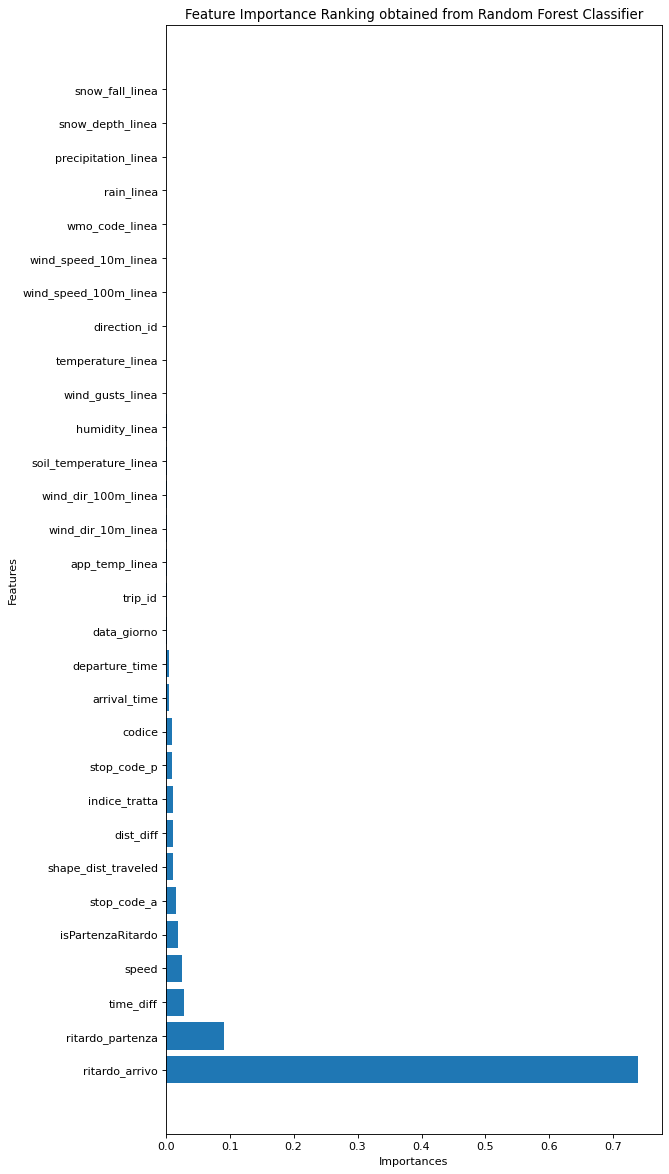

In [32]:
importances = pd.DataFrame({
    "Feature": list(X.columns),
    "Importance": model.feature_importances_
})
importances = importances.sort_values(by="Importance", ascending=False)
importances = importances.set_index("Feature")
importances
plt.figure(figsize=(8, 18), dpi=80)
plt.barh(importances.index, importances.Importance)
plt.title("Feature Importance Ranking obtained from Random Forest Classifier", fontsize=12)
plt.xlabel("Importances")
plt.ylabel("Features")
plt.savefig("../images/data_analytics_images/Feature_Importances_stat.png")

# Balance of the Dataset 

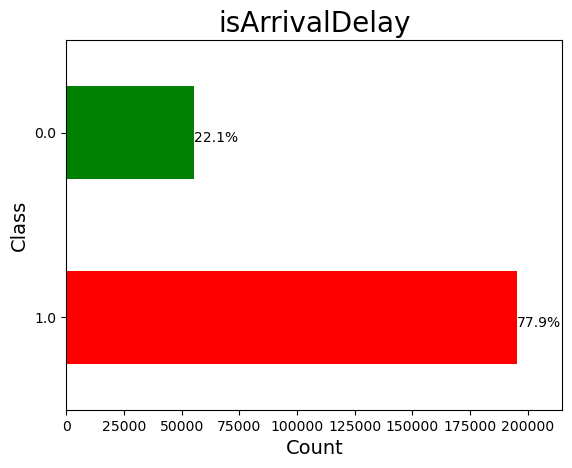

isArrivalDelay
1.0    195574
0.0     55485
Name: count, dtype: int64


In [33]:
# Plotting the percentage of observations that fall under each class
main_dataset_dropped = main_dataset_dropped.rename(columns={
    'codice_stazione_p': 'dep_station_code',
    'codice_stazione_a':'arr_station_code',
    'indice_tratta':'line_index',
    'codice':'code',
    'data_giorno':'day_date',
    'stop_code_p':'stop_code_d',
    'ritardo_partenza':'departure_delay',
    'ritardo_arrivo':'arrival_delay',
    'temperature_linea':'temperature_line',
    'app_temp_linea':'app_temp_line',
    'rain_linea':'rain_line',
    'snow_fall_linea':'snow_fall_line',
    'snow_depth_linea':'snow_depth_line',
    'humidity_linea':'humidity_line',
    'precipitation_linea':'precipitation_line',
    'wmo_code_linea':'wmo_code_line',
    'wind_speed_10m_linea':'wind_speed_10m_line',
    'wind_speed_100m_linea':'wind_speed_100m_line',
    'wind_dir_10m_linea':'wind_dir_10m_line',
    'wind_dir_100m_linea':'wind_dir_100m_line',
    'wind_gusts_linea':'wind_gusts_line',
    'soil_temperature_linea':'soil_temperature_line',
    'isArrivoRitardo':'isArrivalDelay',
    'isPartenzaRitardo':'isDepartureDelay'
})

#sort_values()
ax = main_dataset_dropped["isArrivalDelay"].value_counts().plot(kind="barh", color=["r", "g"])
ax.margins(0.10, None)
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
plt.title("isArrivalDelay", fontsize=20)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Class", fontsize=14)
plt.show()
print(main_dataset_dropped["isArrivalDelay"].value_counts())
fig = ax.get_figure()
fig.savefig("../images/data_analytics_images/imbalance.png")

In [34]:
main_dataset_dropped.day_date.max()

20231031

In [35]:
# Giovedì 5 Agosto 2021
summer = main_dataset_dropped.loc[(main_dataset_dropped.day_date == 20210805 )]
# Giovedì 9 Dicembre 2021
xmas = main_dataset_dropped.loc[(main_dataset_dropped.day_date == 20211208 )]

# Giovedì 31 Ottobre 2023
working_day = main_dataset_dropped.loc[(main_dataset_dropped.day_date == 20231031 )]

# Remove this two dates from learning algorithms
main_dataset_dropped = main_dataset_dropped.loc[(main_dataset_dropped.day_date != 20211208 ) &
                                                (main_dataset_dropped.day_date != 20210805) & 
                                               (main_dataset_dropped.day_date != 20231031)]

main_dataset_dropped = main_dataset_dropped.reset_index(drop=True)
summer = summer.reset_index(drop=True)
xmas = xmas.reset_index(drop=True)
working_day = working_day.reset_index(drop=True)

In [36]:
#Save dataset for testing
summer.to_csv('../processed_files/summer.csv')
xmas.to_csv('../processed_files/xmas.csv')
working_day.to_csv('../processed_files/working.csv')

#Save dataset_for_classification
main_dataset_dropped.to_csv('../processed_files/df_for_ml.csv')